<a href="https://colab.research.google.com/github/HKasie/SDV-model/blob/main/SDV_Prepare_your_own_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare your own data
While the SDV offers many publicly available demo datasets, you may want to use one of your own, private datasets for synthetic data creation.

In this notebook, we'll cover the basics of how you can prepare your data for the SDV. This includes loading your data and writing a metadata description of the tables.

_Last Edit: Oct 2, 2024_

# 0. Installation

Install the SDV library.

In [ ]:
%pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.7 MB/s eta 0:00:00


**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart Session`

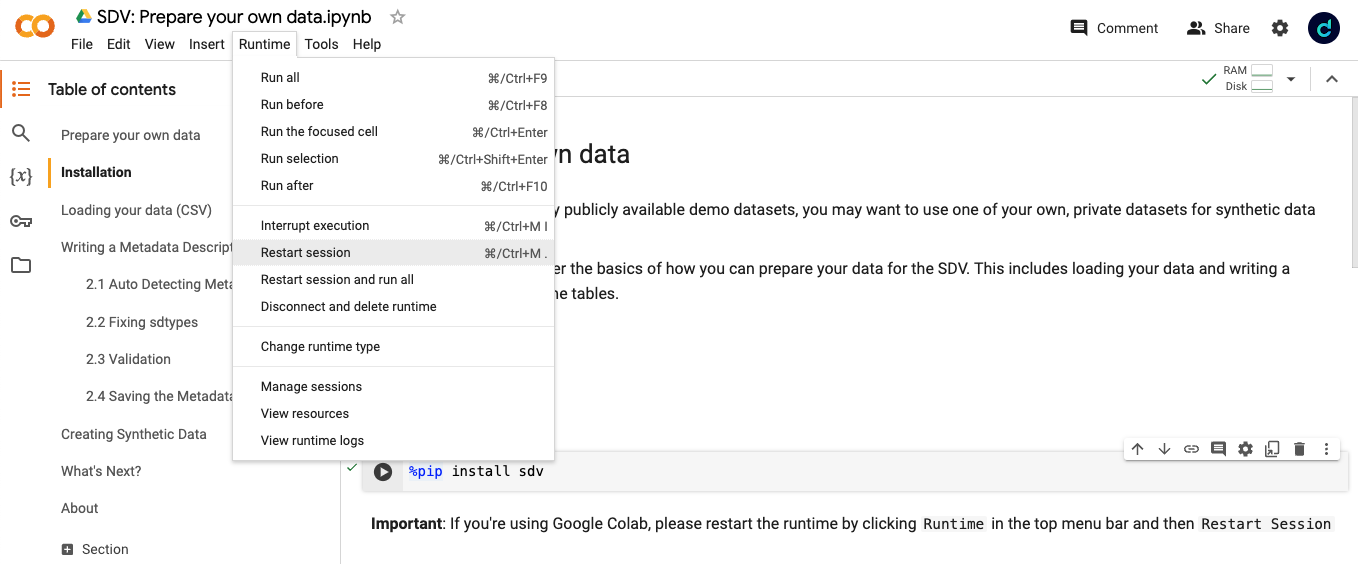

# 1. Loading your data (CSV)

In many cases, your data is available in a CSV file format, where each file the data for a table.

<font color="navy"><b>Run the code below to attach the CSVs to this Google Colab notebook.</b> Click the "Choose Files" button to open up a file picker. Then, choose all the csv files that you'd like to use.</font>

In [ ]:
from google.colab import files

# Optional: You can skip this step if you are running the code on your own
# machine
uploaded = files.upload()

All the csv files are now available in a folder called `content/`. Now we can use the built-in SDV function to read all the csv files in a folder.

In [ ]:
from sdv.datasets.local import load_csvs
from sdv.datasets.demo import download_demo

# This is the default folder name that the GOogle Colab notebook uses.
# Change this if you have your own folder with CSV files.
FOLDER_NAME = 'content/'

try:
  data = load_csvs(folder_name='/content/')
except ValueError:
  print('You have not uploaded any csv files. Using some demo data instead.')
  data, _ = download_demo(
    modality='multi_table',
    dataset_name='fake_hotels'
  )

Now, you should have a dictionary called `datasets`. Inside of it, you'll see the name of every table (csv file) mapped to the actual data that it contains.

In [ ]:
data.keys()

dict_keys(['guests', 'hotels'])

The data is loaded as a `pandas.DataFrame` object. The SDV uses these data frames to easily manipulate and model the data.

In [ ]:
hotels_table = data['hotels']

# use the head method to inspect the first few rows of the data
hotels_table.head(3)

,hotel_id,city,state,rating,classification
0,HID_000,Boston,Massachusetts,4.8,RESORT
1,HID_001,Boston,Massachuesetts,4.1,CHAIN
2,HID_002,San Francisco,California,3.8,MOTEL


In [ ]:
guests_table = data['guests']

guests_table.head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,awolf@phillips.com,HID_000,False,BASIC,37.89,27 Dec 2020,28 Dec 2020,156.23,"993 Rebecca Landing\nJesseburgh, PA 05072",4075084747483975747
1,tonya44@wilkinson-wilkins.com,HID_000,False,BASIC,24.37,30 Dec 2020,31 Dec 2020,139.43,"958 Beverly Bypass\nSouth Ronald, GA 46368",180072822063468
2,harriskathleen@goodwin.com,HID_000,True,DELUXE,0.00,17 Sep 2020,19 Sep 2020,403.33,"8302 Nathaniel Pike\nRileyland, TX 71613",38983476971380


# 2. Writing a Metadata Description
The SDV requires that you provide a description of your data, also known as **metadata**.

The metadata describes the types of data that are available in every column. If you have multiple tables, it also describes how those tables are connected.

## 2.1 Auto Detecting Metadata
The easiest way to create our metadata object is by auto-detecting it from our data.

<font color="maroon"><b>Warning: The detected metadata is not guaranteed to be accurate or complete.</b> We'll update it later to correct it.</font>

In [ ]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframes(data)

We can inspect the auto detected metadata:

Auto detected data:



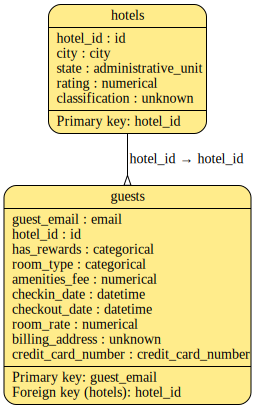

In [ ]:
print('Auto detected data:\n')
metadata.visualize()

The metadata auto-detected the connection between the `hotels` and `guests` table. Each column is associated with an **sdtype**, which describes the type of data.

Notice that the sdtypes vary:
- Statistical sdtypes such as `categorical`, `datetime` and `numerical` provide more general information about the type of data
- Semantic sdtypes such as `credit_card_number` and `city` provide higher level information that is understandable to humans

For more information, see the [sdtypes docs page](https://docs.sdv.dev/sdv/reference/metadata-spec/sdtypes).

<font color="red"><b>The auto-detected metadata is not guaranteed to be accurate or complete.</b></font> For example, notice how some of the columns are shown as `unknown` sdtype. Let's fix these columns to make it more accurate.

## 2.2 Fixing sdtypes

**Hotels table**: Let's start with the hotels.

The `classification` column is meant to be a discrete variable, so we can update it to be categorical.


In [ ]:
metadata.update_column(
    table_name='hotels',
    column_name='classification',
    sdtype='categorical'
)

Notice that `city` and `state` are marked with special sdtypes `city` and `administrative_unit`. SDV's sdtypes include higher-level concepts like this for better modeling.

By default, these higher level concepts are considered **PII**, meaning that SDV will anonymize these columns. You can turn this off by marking PII as False.

In [ ]:
metadata.update_column(
    table_name='hotels',
    column_name='state',
    sdtype='administrative_unit',
    pii=False
)

**Guests table**: Now we can move onto the guests table.

The `billing_address` is currently marked as unknown. This is a PII value. Let's update this in the metadata too.

In [ ]:
metadata.update_column(
    table_name='guests',
    column_name='billing_address',
    sdtype='address',
    pii=True
)

## 2.3 Validation
Now, the metadata should be accurate. Let's validate that the metadata format makes sense. If successful, the code below should run without any errors.

In [ ]:
metadata.validate()

We can also validate that the metadata accurately matches the data that we provided. Similar to before, the code below should run without any errors.

In [ ]:
metadata.validate_data(data=data)

Finally, we can also visualize the final structure data to verify that the columns and connections are ok.

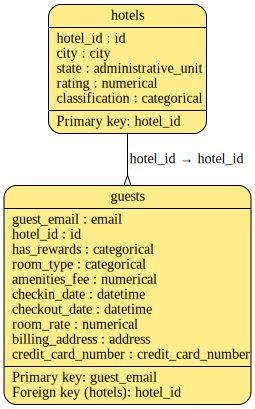

In [ ]:
metadata.visualize()

## 2.4 Saving the Metadata
We **highly recommend saving the metadata** as a `JSON` object so we can re-use this description whenever we need to.

In [ ]:
metadata.save_to_json('metadata.json')

# in the future, you can reload the metadata object from the file
metadata = Metadata.load_from_json('metadata.json')

# 3. Creating Synthetic Data
With these preparatory steps completed, we can now use the metadata description and data in the SDV. The coe below will train a model and create synthetic data.

In [ ]:
from sdv.multi_table import HMASynthesizer

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(data)
synthetic_data = synthesizer.sample(scale=1)

Preprocess Tables: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]



Learning relationships:


(1/1) Tables 'hotels' and 'guests' ('hotel_id'): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Modeling Tables: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


The synthetic data contains the same tables, columns and connections as the real data.

In [ ]:
synthetic_data['hotels'].head(3)

,hotel_id,city,state,rating,classification
0,sdv-id-UpYymO,Samanthachester,New York,4.2,CHAIN
1,sdv-id-CxrCUU,South Nicolefort,California,4.8,RESORT
2,sdv-id-PIQQQy,Port Danielport,New York,4.3,CHAIN


In [ ]:
synthetic_data['guests'].head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,moodyeric@example.net,sdv-id-UpYymO,False,BASIC,26.56,15 Nov 2020,23 Oct 2020,88.68,"PSC 4273, Box 0888\nAPO AA 28423",5161033759518983
1,coryguzman@example.com,sdv-id-UpYymO,False,BASIC,18.22,09 Jun 2020,15 Mar 2020,88.97,"417 Lawrence Hollow\nEast Ericshire, IN 65660",4133047413145475690
2,caitlinlee@example.net,sdv-id-UpYymO,False,BASIC,11.87,09 Sep 2020,30 Aug 2020,88.68,"69754 Mcguire Haven Apt. 260\nCrawfordside, IN...",4977328103788


# 4. What's Next?

Visit the **[metadata documentation](https://docs.sdv.dev/sdv/reference/metadata-spec)** for more information.

You may also be interested in our tutorials for **[synthesizing a table](https://colab.research.google.com/drive/1XCwu7NaCYXf3kkhlx4Iei4w2KrXzr1zo)** or **[synthesizing multi tables](https://colab.research.google.com/drive/1h_xwzHXrif-xEOC39amYC6xfNPu5hDA1)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

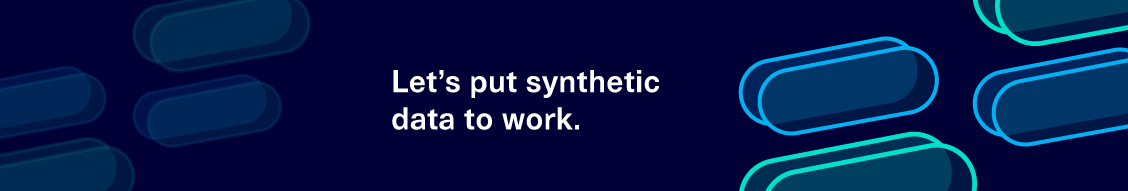